In [3]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.util import read_data_chars, add_gpu_chars_to_df, read_gpu_chars, read_results
from src.analytical_model import load_X, LinRegEnsemble
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
df, dep, indep = load_X()
df.columns
inspect = df.head(1).T

2024-04-01 14:59:46.065 | INFO     | src.analytical_model:load_X:35 - Loading data for analytical model


2024-04-01 14:59:47.443 | INFO     | src.analytical_model:load_X:84 - Loaded data for analytical model with 24 dependent variables and 61 independent variables


In [5]:
sorted(indep)

['13',
 '14',
 '24',
 '25',
 'FR',
 'TR',
 'c_T',
 'cardinality_S',
 'cardinality_T',
 'comp_colsum',
 'comp_fac',
 'comp_fac_col_major',
 'comp_lmm_fac',
 'comp_lmm_mat',
 'comp_mat',
 'comp_mat_col_major',
 'comp_matrix_dense',
 'comp_ratio',
 'comp_rmm_fac',
 'comp_rmm_mat',
 'comp_rowsum',
 'comp_scalar_dense',
 'comp_scalar_fac',
 'comp_scalar_mat',
 'complexity_ratio',
 'fr',
 'gpu__cores',
 'gpu__number_of_sm',
 'gpu_cache_size_l1',
 'gpu_cache_size_l2',
 'gpu_clock_speed_base',
 'gpu_clock_speed_max_boost',
 'gpu_memory_bandwidth',
 'gpu_memory_bus_width',
 'gpu_memory_clock',
 'gpu_memory_size',
 'gpu_processing_power_double_precision',
 'gpu_processing_power_half_precision',
 'gpu_processing_power_single_precision',
 'mem_fac_read',
 'mem_fac_write',
 'mem_mat_read',
 'mem_mat_write',
 'mem_read_colsum',
 'mem_read_matrix_dense',
 'mem_read_rowsum',
 'mem_read_scalar_dense',
 'mem_write_colsum',
 'mem_write_matrix_dense',
 'mem_write_rowsum',
 'mem_write_scalar_dense',
 'morp

### Option , Lin Reg ensemble
- predict 'memory_throughput_byte_weighted_mean', 'dram_bytes_sum' separately
- single regressor per (type, operator, ycol)

Separate prediction for bytes sum and throughput bytes

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import PredictionErrorDisplay
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(df[indep]), index=df.index, columns=indep)
y = df[dep]

train, test = train_test_split(df, test_size=0.3, random_state=42)
X_train = X.loc[train.index]
X_test = X.loc[test.index]
y_train = y.loc[train.index]
y_test = y.loc[test.index]

def create_and_eval_model(targets, target_to_pred_func, split_by=["operator", "model"]):
    model = LinRegEnsemble(
        train,
        X_train,
        y_train[targets],
        LinearRegression,
        split_by=split_by,
        target_to_pred_func=target_to_pred_func, 
        # clf_kwargs={"fit_intercept": True, }
    )

    pred = model.predict(test, X_test)
    y_true = target_to_pred_func(y_test)
    # ax = PredictionErrorDisplay.from_predictions(y_true, pred).plot()
    ax = sns.scatterplot(x=y_true,y= pred)
    # ax.set_xlim(0,1)
    # ax.set_ylim(0,1)
    plt.title(f"targets: {targets}\nmse: {mean_squared_error(y_true, pred): .4f}, r2: {r2_score(y_true, pred): .4f}")
    ax.plot([0,10],[0,10], color='red')
    ax.set_xlabel("True value")
    ax.set_xlabel("Predicted value")
    return model

In [7]:

# targets = ["dram_bytes_sum", "memory_throughput_byte_weighted_mean"]
# analytical1 = create_and_eval_model(targets, lambda x: x.dram_bytes_sum / x.memory_throughput_byte_weighted_mean)

Separate prediction for bytes_read, bytes_write, throughput_sum

In [8]:
# targets = ['dram_bytes_read_sum', 'dram_bytes_write_sum', 'memory_throughput_byte_weighted_mean']
# analytical2 = create_and_eval_model(targets, lambda x: (x.dram_bytes_read_sum + x.dram_bytes_write_sum) / x.memory_throughput_byte_weighted_mean)

2024-04-01 15:03:18.148 | INFO     | src.analytical_model:create_linreg_ensemble:183 - Creating a linear regression ensemble for the analytical model, splitting by ['operator', 'model']


2024-04-01 15:03:21.746 | INFO     | src.analytical_model:create_linreg_ensemble:211 - Created a linear regression ensemble for the analytical model with 24 models
2024-04-01 15:03:21.747 | DEBUG    | src.analytical_model:predict_linreg_ensemble:105 - Predicting results of the analytical model using a linear regression ensemble


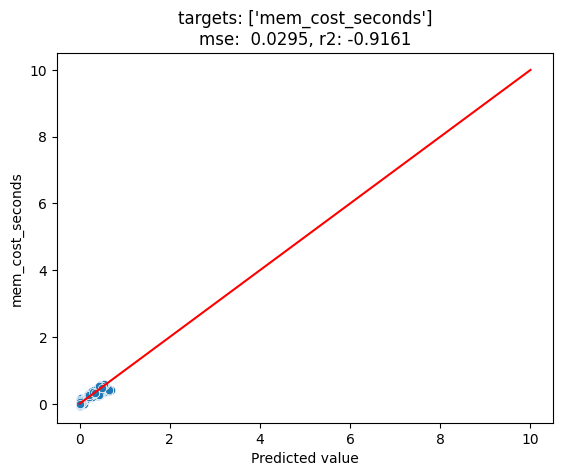

In [18]:
targets = ['mem_cost_seconds']
analytical3 = create_and_eval_model(targets, lambda x: (x.mem_cost_seconds))

In [19]:
mean_squared_error(y_test.mem_cost_seconds, pred)

0.029471106405192724

2024-04-01 15:08:43.285 | DEBUG    | src.analytical_model:predict_linreg_ensemble:105 - Predicting results of the analytical model using a linear regression ensemble


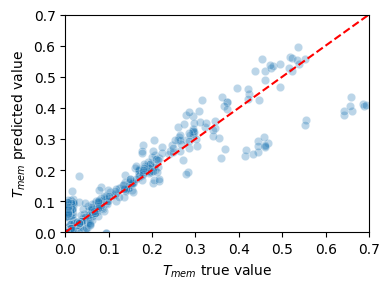

In [37]:
pred = analytical3.predict(test, X_test)
fig, ax = plt.subplots(figsize=(0.5*8,3))
sns.scatterplot(x=y_test.mem_cost_seconds, y=pred, ax=ax, alpha=0.3)
ax.set_xlabel("$T_{mem}$ true value")
ax.set_ylabel("$T_{mem}$ predicted value")
ax.plot([0,0.7],[0,0.7], color='red', linestyle='--')
ax.set_xlim(0,0.7)
ax.set_ylim(0,0.7)
# ax.grid()
# ax.set_axisbelow(True)
fig.tight_layout()
fig.savefig("/home/pepijn/Documents/uni/y5/thesis/writing/overleaf/chapters/05_cost_estimation/figures/analytical-regressor-fit.pdf")

In [ ]:
pd.DataFrame({"true": test.mem_cost_seconds, "pred": analytical3.predict(test, X_test)}).corr()


2024-04-01 14:51:19.557 | DEBUG    | src.analytical_model:predict_linreg_ensemble:105 - Predicting results of the analytical model using a linear regression ensemble


,true,pred
true,1.000000,0.937923
pred,0.937923,1.000000


## Predict cost for train data

In [ ]:
from src.analytical_model import ModelCost
from src.util import model_operators, train_test_validate_split
import threading

results_df = read_results()

results_df['mem_fac_sum']=results_df.mem_fac_read + results_df.mem_fac_write
results_df['mem_mat_sum'] = results_df.mem_mat_read + results_df.mem_mat_write
results_df['mem_diff'] = (results_df.mem_mat_sum - results_df.mem_fac_sum)/4e10
results_df['mem_ratio'] = results_df.mem_mat_sum / results_df.mem_fac_sum


train, test, validate = train_test_validate_split(results_df)
test = test[test.operator.isin(model_operators)]
# Create cost_test and cost_validate dataframes
cost_test = pd.DataFrame(scaler.transform(test[[*indep]]), columns=indep, index=test.index)
cost_validate = pd.DataFrame(scaler.transform(validate[[*indep]]), columns=indep, index=validate.index)

# Add 'operator' column to both dataframes
cost_test['operator'] = test[['operator']]
cost_test = cost_test.fillna(0.)
cost_validate['operator'] = validate[['operator']]
cost_validate = cost_validate.fillna(0.)

train set:
	Records: 210953
	Positive (speedup > 1 with factorizing)/Negative: 39648/171305 = 0.23 s
	Dataset types: ['synthetic' 'hamlet']
\Compute Units: ['v100' 'CPU 08c' 'p100' 'CPU 16c' '1080' 'CPU 32c' '2080' 'a40']
test set:
	Records: 90409
	Positive (speedup > 1 with factorizing)/Negative: 16772/73637 = 0.23 s
	Dataset types: ['synthetic' 'hamlet']
\Compute Units: ['CPU 32c' '2080' 'CPU 16c' '1080' 'CPU 08c' 'v100' 'p100' 'a40']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


In [ ]:
# Define a function for each thread
def compute_cost_1(df,indexer_df):
    return
    df['computed_cost_dict1'] = ModelCost(analytical1, indexer_df).predict(df)

def compute_cost_2(df,indexer_df):
    return
    df['computed_cost_dict2'] = ModelCost(analytical2, indexer_df).predict(df)

def compute_cost_3(df,indexer_df):
    df['computed_cost_dict3'] = ModelCost(analytical3, indexer_df).predict(df)

# Create threads for cost_test
threads = []
for i, compute_cost in enumerate([compute_cost_1, compute_cost_2, compute_cost_3]):
    thread = threading.Thread(target=compute_cost, args=(cost_test, test))
    threads.append(thread)

# Create threads for cost_validate
for i, compute_cost in enumerate([compute_cost_1, compute_cost_2, compute_cost_3]):
    thread = threading.Thread(target=compute_cost, args=(cost_validate,validate))
    threads.append(thread)

# Start threads for cost_validate
for thread in threads:
    thread.start()

# Wait for all threads to complete for cost_validate
for thread in threads:
    thread.join()

print('completed threads')

  0%|          | 0/20295 [00:00<?, ?it/s]


100%|██████████| 20295/20295 [16:22<00:00, 20.65it/s]

completed threads


In [ ]:
cost_validate['computed_cost_dict3']

158716    {'LMM': [-29.218600566083186, 0.80024874120411...
158717    {'MM': [-6244.401532825992, -4943.762313908218...
158718    {'exp': [0.44887587894736447, 0.37413413388313...
158719    {'LMM': [-7.304649968292143, 0.200062185763726...
158734    {'LMM': [-29.160229791869348, 0.81713141516675...
                                ...                        
347740    {'LMM': [-1410.287781093136, 132.9878275767338...
347741    {'MM': [-476799.3718089326, -377638.4416436007...
347742    {'LMM': [-352.57193204734176, 33.2469569295102...
347743    {'LMM': [-1542.3549705153891, 147.722710975295...
347744    {'MM': [-507325.7364197032, -401807.3257985], ...
Name: computed_cost_dict3, Length: 11187, dtype: object

In [ ]:
try:
    for i, df in enumerate([cost_test, cost_validate], 1):
        for j in range(3, 4):
            df[f'mat_cost_{j}'] = df[f'computed_cost_dict{j}'].apply(lambda x: x.get('sum')[0])
            df[f'fact_cost_{j}'] = df[f'computed_cost_dict{j}'].apply(lambda x: x.get('sum')[1])
            df[f'cost_label_{j}'] = df[f'mat_cost_{j}'] > df[f'fact_cost_{j}']
            df[f'cost_diff_{j}'] = df[f'mat_cost_{j}'] - df[f'fact_cost_{j}']
            df[f'cost_ratio_{j}'] = df[f'mat_cost_{j}'] / df[f'fact_cost_{j}']
            outfile = "analytical_cost_with_dict_test.parquet" if i == 1 else "analytical_cost_with_dict_validate.parquet"
            df.to_parquet(outfile)
except Exception:
    print("reading results")
    # cost_test = pd.read_parquet("analytical_cost_with_dict_test.parquet")
    # cost_validate = pd.read_parquet("analytical_cost_with_dict_validate.parquet")


In [ ]:
cost_test[['mat_cost_3', 'fact_cost_3', 'cost_label_3', ]].describe()


,mat_cost_3,fact_cost_3
count,20295.000000,20295.000000
mean,-9217.191665,-7273.823341
std,16962.091505,13451.974017
min,-62447.912628,-49466.802776
25%,-6236.697937,-4941.751552
50%,-1511.410628,-1076.364680
75%,-368.671870,-266.319991
max,-40.784069,-30.688925


In [ ]:
from src.util import eval_result
target_col='time_saved'
def plot_boundary(y_true, y_pred, lower=-1., upper=1., step=0.1, target_col=target_col, full_dataset=test, ax=None):
    # Create a list to store the results
    results = []

    # Loop over the range of boundaries
    x= np.arange(lower, upper, step)
    for boundary in x:
        result = eval_result(y_true, y_pred = y_pred > boundary, full_dataset=full_dataset, target_col=target_col)
        results.append({'boundary': boundary, **result[2]})

    dd = pd.DataFrame(results)
    
    ax=sns.scatterplot(data=dd, x="boundary", y="y_pred_time_saved", label='time_saved',ax=ax)
    sns.scatterplot(data=dd, x="boundary", y="y_pred_speedup_real", ax=ax.twinx(), label='speedup', color='orange',alpha=0.5)
    ax.grid()
    ax.legend(loc='lower right')
    return ax

In [ ]:
# # loc =cost_df.dataset_type != 'synthetic'
# fig, axs = plt.subplots(2,2, figsize=(15,10))
# fig.suptitle("Boundary for analytical 1")
# for i, (ax, cost_df, full_df, type) in enumerate(zip(axs, [cost_test, cost_validate], [test, validate], ['test', 'validate'])):
#     plot_boundary(full_df.time_saved, cost_df.cost_diff_1, lower=-1,  upper=1, step=0.05, target_col=None, full_dataset=full_df, ax=ax[0])
#     plot_boundary(full_df.time_saved, cost_df.cost_ratio_1, lower=-100,  upper=100, step=2, target_col=None, full_dataset=full_df, ax=ax[1])
#     ax[0].set_title(f"diff {type}")
#     ax[1].set_title(f"ratio {type}")
# fig.tight_layout()

In [ ]:
# # loc =cost_df.dataset_type != 'synthetic'
# fig, axs = plt.subplots(2,2, figsize=(15,10))
# fig.suptitle("Boundary for analytical 2")
# for i, (ax, cost_df, full_df, type) in enumerate(zip(axs, [cost_test, cost_validate], [test, validate], ['test', 'validate'])):
#     plot_boundary(full_df.time_saved, cost_df.cost_diff_2, lower=-1,  upper=1, step=0.05, target_col=None, full_dataset=full_df, ax=ax[0])
#     plot_boundary(full_df.time_saved, cost_df.cost_ratio_2, lower=-100,  upper=100, step=2, target_col=None, full_dataset=full_df, ax=ax[1])
#     ax[0].set_title(f"diff {type}")
#     ax[1].set_title(f"ratio {type}")
# fig.tight_layout()

In [ ]:
cost_test.cost_diff_3.describe()

count    20295.000000
mean     -1943.368324
std       3511.406495
min     -12996.538878
25%      -1294.470418
50%       -423.374444
75%       -100.847409
max         -9.038572
Name: cost_diff_3, dtype: float64

/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0

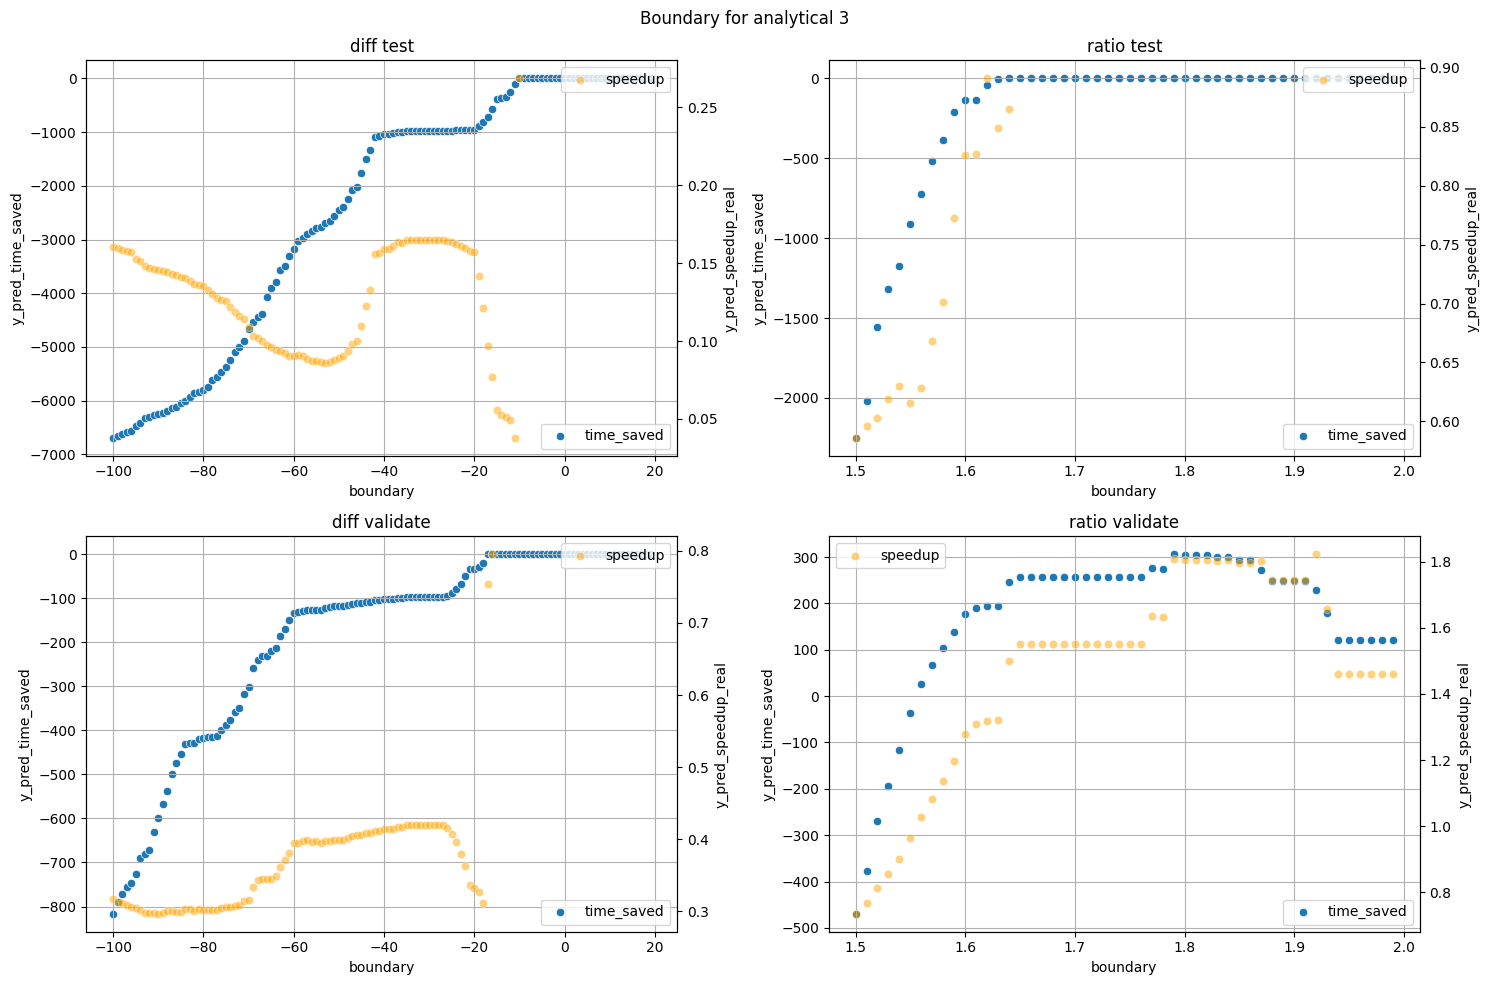

In [ ]:
# loc =cost_df.dataset_type != 'synthetic'
fig, axs = plt.subplots(2,2, figsize=(15,10))
fig.suptitle("Boundary for analytical 3")
for i, (ax, cost_df, full_df, type) in enumerate(zip(axs, [cost_test, cost_validate], [test, validate], ['test', 'validate'])):
    plot_boundary(full_df.time_saved, cost_df.cost_diff_3, lower=-100,  upper=20, step=1, target_col=None, full_dataset=full_df, ax=ax[0])
    plot_boundary(full_df.time_saved, cost_df.cost_ratio_3, lower=1.5,  upper=2, step=0.01, target_col=None, full_dataset=full_df, ax=ax[1])
    ax[0].set_title(f"diff {type}")
    ax[1].set_title(f"ratio {type}")
fig.tight_layout()

In [ ]:
# Apply the same operations to cost_test and cost_validate
cost_test['mem_fac_sum'] = test.mem_fac_read + test.mem_fac_write
cost_test['mem_mat_sum'] = test.mem_mat_read + test.mem_mat_write
cost_test['mem_diff'] = (test.mem_mat_sum - test.mem_fac_sum)/4e10
cost_test['mem_ratio'] = test.mem_mat_sum / test.mem_fac_sum
cost_test.mem_diff.describe()

cost_validate['mem_fac_sum'] = validate.mem_fac_read + validate.mem_fac_write
cost_validate['mem_mat_sum'] = validate.mem_mat_read + validate.mem_mat_write
cost_validate['mem_diff'] = (validate.mem_mat_sum - validate.mem_fac_sum)/4e10
cost_validate['mem_ratio'] = validate.mem_mat_sum / validate.mem_fac_sum
cost_validate.mem_diff.describe()

count    11187.000000
mean         1.691918
std          5.376524
min         -7.661454
25%         -0.000200
50%          0.172807
75%          1.434072
max        104.050591
Name: mem_diff, dtype: float64

/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0

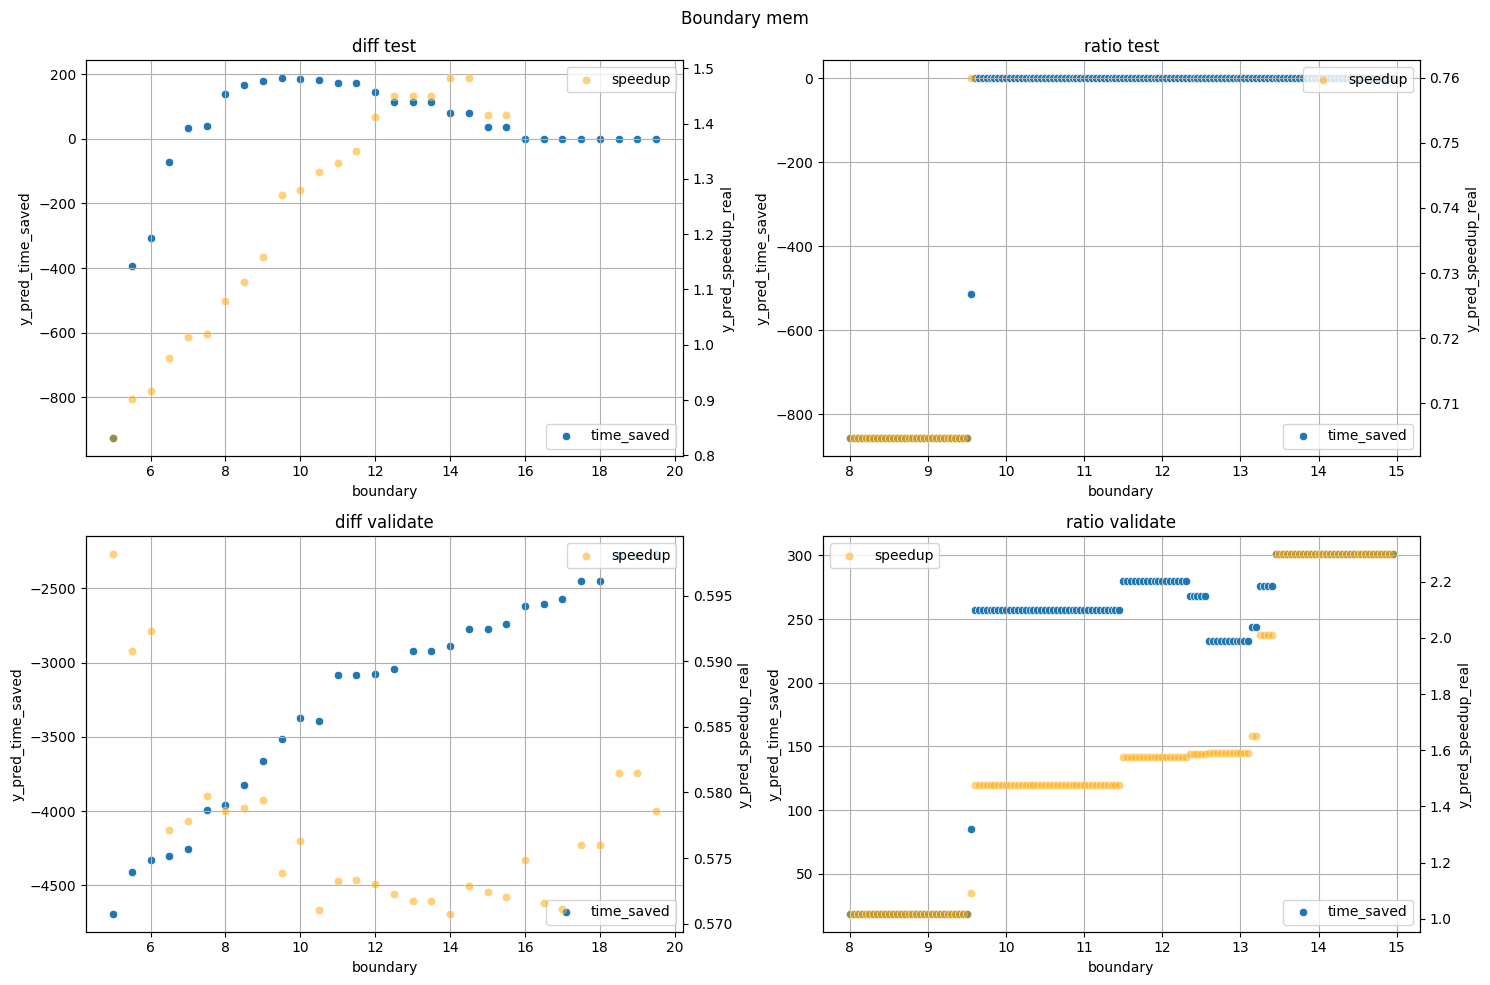

In [ ]:
# loc =cost_df.dataset_type != 'synthetic'
fig, axs = plt.subplots(2,2, figsize=(15,10))
fig.suptitle("Boundary mem")
for i, (ax, cost_df, full_df, type) in enumerate(zip(axs, [cost_test, cost_validate], [test, validate], ['test', 'validate'])):
    plot_boundary(full_df.time_saved, cost_df.mem_diff, lower=5,  upper=20, step=0.5, target_col=None, full_dataset=full_df, ax=ax[0])
    plot_boundary(full_df.time_saved, cost_df.mem_ratio, lower=8,  upper=15, step=0.05, target_col=None, full_dataset=full_df, ax=ax[1])
    ax[0].set_title(f"diff {type}")
    ax[1].set_title(f"ratio {type}")
fig.tight_layout()

/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'y_true_mat_time': 4675.457687211972,
 'y_true_fact_time': 3222.5951272408565,
 'y_true_best_time': 3222.5951272408565,
 'y_true_time_saved': 1452.8625599711158,
 'y_true_speedup_avg': 1.6600671791388428,
 'y_true_speedup_real': 1.4508362057926394,
 'y_pred_mat_time': 0.0,
 'y_pred_fact_time': 0.0,
 'y_pred_best_time': 0.0,
 'y_pred_time_saved': 0.0,
 'y_pred_speedup_avg': nan,
 'y_pred_speedup_real': nan,
 'TP': (0, nan),
 'FP': (0, nan),
 'TN': (18714, 0.39720735719515765),
 'FN': (1581, 1.6600671791388428)}

In [ ]:
axes

{'A': <Axes: label='A'>, 'B': <Axes: label='B'>}

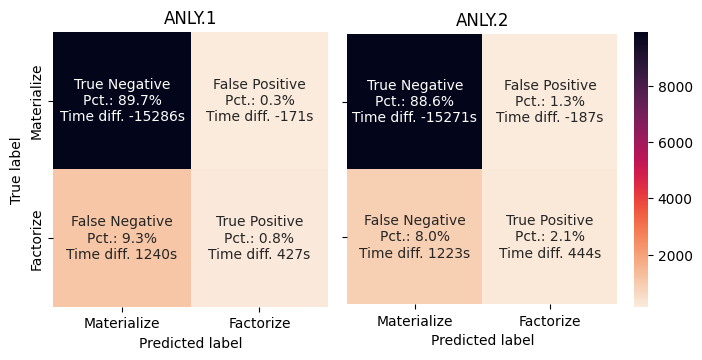

In [ ]:
from sklearn.metrics import confusion_matrix
labels  =[]
fig, axes = plt.subplot_mosaic("AAAAABBBBBB", sharex=True, sharey=True, figsize=(0.9*8, 3.5))

for pred, name, ax in zip([cost_validate.cost_ratio_3 > 1.7, validate.mem_ratio > 10.0], ['ANLY.1', 'ANLY.2'], axes.values()):
    y_true,y_pred = validate.label, pred
    speedup_dict = eval_result(y_true, y_pred, validate, target_col='label', plot=False)[2]

    cf = confusion_matrix(y_true, y_pred)

    group_counts = ["Counts: {0:0.0f}".format(value) for value in cf.flatten()]
    group_percentages = ["Pct.: {0:.1%}".format(value) for value in cf.flatten() / np.sum(cf)]

    group_spdup = [
        "Time diff. {:.0f}s".format(value)
        for value in [
            speedup_dict["TN"][2],
            speedup_dict["FP"][2],
            speedup_dict["FN"][2],
            speedup_dict["TP"][2],
        ]
    ]
    group_names = [
        "True Negative",
        "False Positive",
        "False Negative",
        "True Positive",
    ]

    labels = np.asarray(
        [
            f"{v1}\n{v2}\n{v3}"
            for v1, v2, v3 in zip(group_names, group_percentages, group_spdup)
        ]
    ).reshape(2, 2)

    ax.set_title(name)
    sns.heatmap(cf, annot=labels, cmap="rocket_r", fmt="", ax=ax, cbar=name=='ANLY.2',square=True)
    ax.set_yticklabels(["Materialize", "Factorize"], rotation=90)
    ax.set_xticklabels(["Materialize", "Factorize"])
    ax.set_xlabel("Predicted label")
    if name == 'ANLY.1':
        ax.set_ylabel("True label")
fig.tight_layout()
fig.savefig("/home/pepijn/Documents/uni/y5/thesis/writing/overleaf/chapters/05_cost_estimation/figures/analytical-models-compare.pdf")

/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_128507/2836567859.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
/tmp/ipykernel_128507/2836567859.py:21: UserWarning: Fix

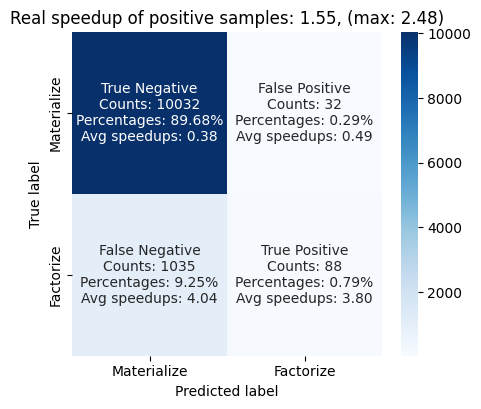

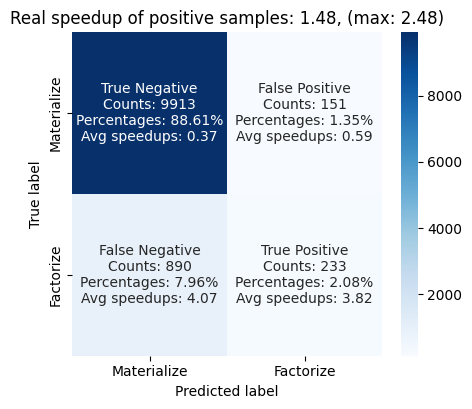

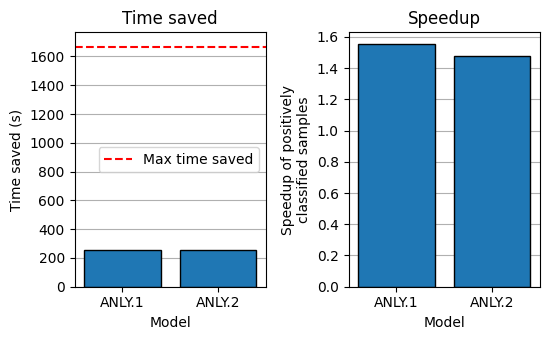

In [ ]:
r2 = eval_result(test.label, test.mem_ratio> 10, test, target_col='label')[0]['speedup']
r1 = eval_result(test.label, cost_test.cost_ratio_3 > 1.7, test, target_col='label')[0]['speedup']
res_test = pd.DataFrame({"ANLY.1": r1, "ANLY.2": r2}).T
res_test

r1_val = eval_result(validate.label, cost_validate.cost_ratio_3 > 1.7, validate, target_col='label', plot=True)[0]['speedup']
r2_val = eval_result(validate.label, validate.mem_ratio > 10, validate, target_col='label', plot=True)[0]['speedup']

res_val = pd.DataFrame({"ANLY.1": r1_val, "ANLY.2": r2_val}).T
res_val
res_val['Model'] = res_val.index
res_val['fraction_of_optimal_time_saved'] = res_val.y_pred_time_saved / res_val.y_true_time_saved
palette = []
f, axs = plt.subplots(1,2, figsize=(0.7*8,3.5))
labels = ["Time saved (s)", "Speedup of positively\nclassified samples"]
titles = ["Time saved", "Speedup", "Performance"]
max_time_saved = res_val.y_true_time_saved.max()
max_speedup = res_val.y_pred_speedup_real.max()
for ax, var, label, title in zip(axs, ['y_pred_time_saved', 'y_pred_speedup_real'], labels, titles):
    sns.barplot(data=res_val, x='Model', y=var, ax=ax, palette=None, saturation=1, edgecolor = "black", linewidth=1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    ax.set_ylabel(label)
    # ax.set_xlabel("Cost Model")
    ax.set_title(title)
    if var =='y_pred_time_saved':
        ax.axhline(max_time_saved, color='red', linestyle='--', label="Max time saved")
        ax.set_ylim(top=max_time_saved+100)
        ax.legend()
    elif var == 'y_pred_time_saved':
        ax.axhline(max_time_saved, color='red', linestyle='--', label="Max speedup")
        ax.legend()
    
f.tight_layout()
# f.savefig("/home/pepijn/Documents/uni/y5/thesis/writing/overleaf/chapters/05_cost_estimation/figures/stat-models-compare.pdf", bbox_inches='tight')

In [ ]:
pd.DataFrame({f"analytical_y_true": validate.label, f"analytical_y_pred": validate.mem_ratio >10.}).to_csv(
        f"evaluation/predictions/analytical2_mem_ratio_label.csv"
    )

In [ ]:
pd.DataFrame({f"analytical_y_true": validate.label, f"analytical_y_pred": cost_validate.cost_ratio_3 > 1.7}).to_csv(
        f"evaluation/predictions/analytical1_pred_mem_ratio_label.csv"
    )

/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/amalur-factorization/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0

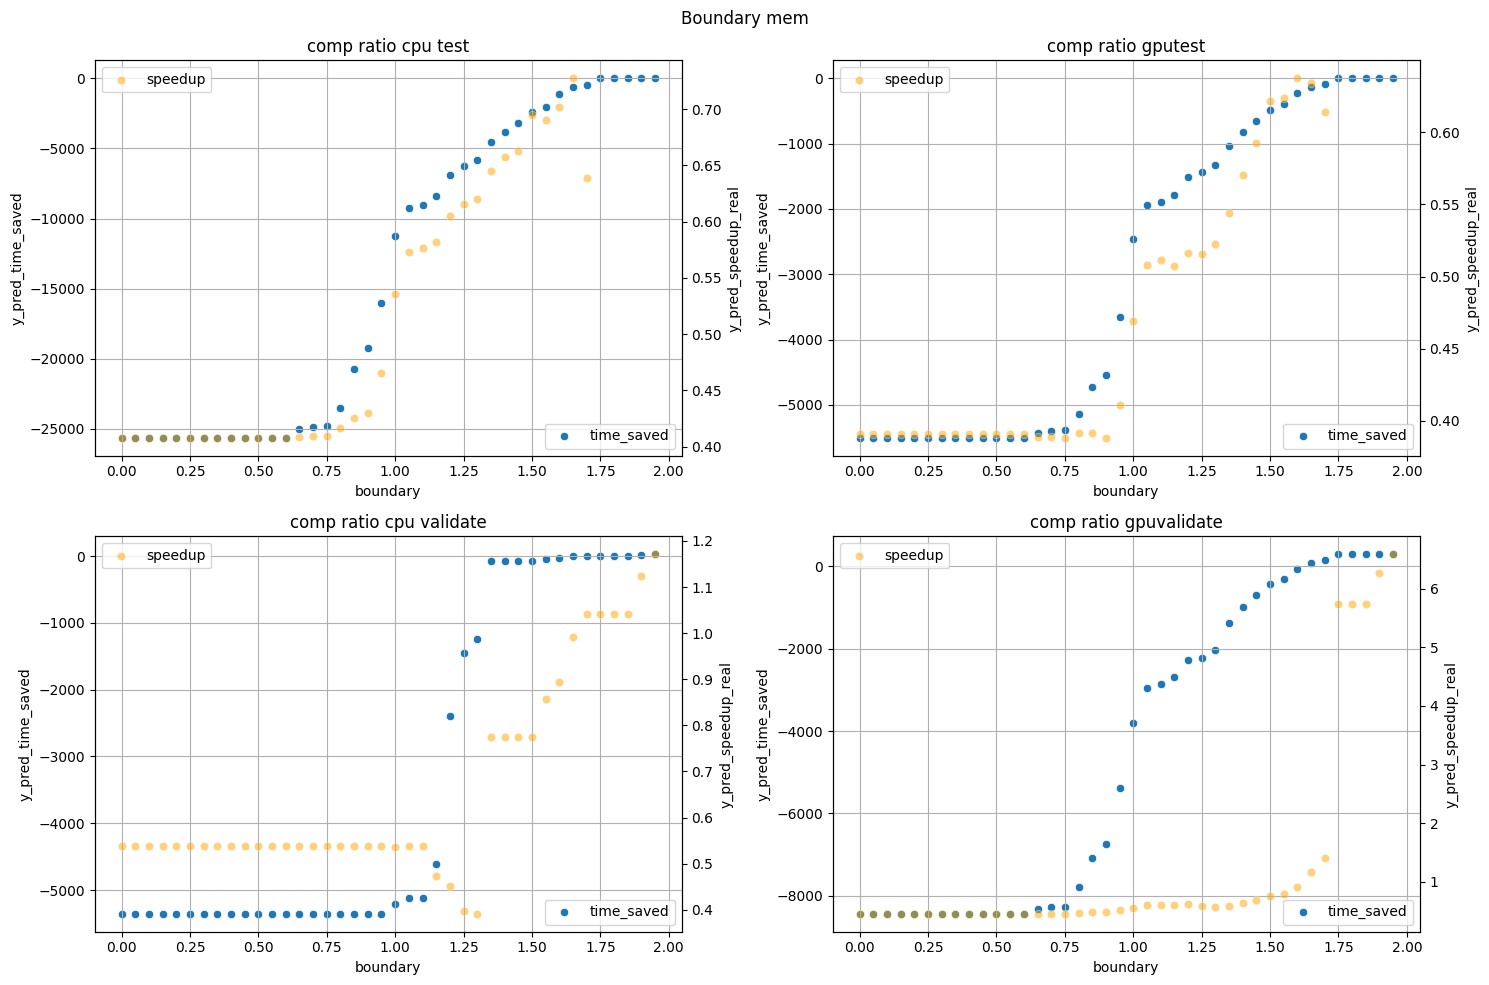

In [ ]:
# loc =cost_df.dataset_type != 'synthetic'
fig, axs = plt.subplots(2,2, figsize=(15,10))
fig.suptitle("Boundary mem")
for i, (ax, cost_df, full_df, type) in enumerate(zip(axs, [cost_test, cost_validate], [test, validate], ['test', 'validate'])):
    loc = full_df[full_df.compute_type=='cpu'].index
    
    plot_boundary(full_df.loc[loc].time_saved, cost_df.loc[loc].comp_ratio, lower=0,  upper=2, step=0.05, target_col=None, full_dataset=full_df.loc[loc], ax=ax[0])
    
    loc = full_df[full_df.compute_type=='gpu'].index
    plot_boundary(full_df.loc[loc].time_saved, cost_df.loc[loc].comp_ratio, lower=0,  upper=2, step=0.05, target_col=None, full_dataset=full_df.loc[loc], ax=ax[1])
    ax[0].set_title(f"comp ratio cpu {type}")
    ax[1].set_title(f"comp ratio gpu {type}")
fig.tight_layout()

In [ ]:
cost_df.comp_ratio.describe()

count    49029.000000
mean         1.181548
std          0.294227
min          0.601594
25%          0.950574
50%          1.155220
75%          1.439104
max          1.987629
Name: comp_ratio, dtype: float64